load libraries

In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd

from keras.models import *
from keras.optimizers import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

D:\Users\karl.jiang\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#dir = "D:\Tensorflow\DMS\mlnd_distracted_driver_detection-master\data\distracted_driver_detection\imgs"
dir = "D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\distracted_driver_detection\imgs"

model_image_size = (224, 224)
fine_tune_layer = 22
final_layer = 24
visual_layer = 21
batch_size = 8

def lambda_func(x):
    x /= 255.
    x -= 0.5
    x *= 2
    return x

# 加载数据集

load train data

In [3]:
train_gen = ImageDataGenerator(
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
)
gen = ImageDataGenerator(
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
)

train_generator = train_gen.flow_from_directory(os.path.join(dir, 'train'),  model_image_size, shuffle=True, batch_size=batch_size, class_mode="categorical")
print("subdior to train type {}".format(train_generator.class_indices))
valid_generator = gen.flow_from_directory(os.path.join(dir, 'valid'),  model_image_size, shuffle=True, batch_size=batch_size, class_mode="categorical")
print("subdior to valid type {}".format(valid_generator.class_indices))

D:\Users\karl.jiang\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:770: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 20787 images belonging to 10 classes.
subdior to train type {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}
Found 1637 images belonging to 10 classes.
subdior to valid type {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


# 构建模型

https://github.com/fchollet/keras/blob/master/keras/applications/vgg19.py


In [4]:
input_tensor = Input((*model_image_size, 3))
x = input_tensor
# if lambda_func:
#     x = Lambda(lambda_func)(x)

base_model = VGG19(input_tensor=Input((*model_image_size, 3)), weights='imagenet', include_top=False)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)
model = Model(base_model.input, x)

print("total layer count {}".format(len(base_model.layers)))

for i in range(fine_tune_layer):
    model.layers[i].trainable = False

total layer count 22


# 训练模型

In [5]:
print("train_generator.samples = {}".format(train_generator.samples))
print("valid_generator.samples = {}".format(valid_generator.samples))
steps_train_sample = train_generator.samples // 128 + 1
steps_valid_sample = valid_generator.samples // 128 + 1

train_generator.samples = 20787
valid_generator.samples = 1637


In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator, steps_per_epoch=steps_train_sample, epochs=10, validation_data=valid_generator, validation_steps=steps_valid_sample)

model.save("models/vgg19-imagenet-finetune{}-adam.h5".format(fine_tune_layer))
print("model saved!")

Epoch 1/10


D:\Users\karl.jiang\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:959: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
D:\Users\karl.jiang\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:967: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


163/163 [==============================] - 91s 557ms/step - loss: 10.0588 - acc: 0.1150 - val_loss: 6.1433 - val_acc: 0.2019
Epoch 2/10
163/163 [==============================] - 67s 409ms/step - loss: 8.6254 - acc: 0.1465 - val_loss: 5.0472 - val_acc: 0.1635
Epoch 3/10
163/163 [==============================] - 65s 398ms/step - loss: 7.2373 - acc: 0.2009 - val_loss: 5.5196 - val_acc: 0.2212
Epoch 4/10
163/163 [==============================] - 63s 387ms/step - loss: 5.9164 - acc: 0.2546 - val_loss: 4.5236 - val_acc: 0.2404
Epoch 5/10
163/163 [==============================] - 63s 389ms/step - loss: 4.8953 - acc: 0.2906 - val_loss: 3.4932 - val_acc: 0.3846
Epoch 6/10
163/163 [==============================] - 68s 417ms/step - loss: 4.1329 - acc: 0.3428 - val_loss: 4.2271 - val_acc: 0.2788
Epoch 7/10
163/163 [==============================] - 65s 398ms/step - loss: 3.7328 - acc: 0.3443 - val_loss: 2.2835 - val_acc: 0.4712
Epoch 8/10
163/163 [==============================] - 63s 384ms/s

In [7]:
model.compile(optimizer=RMSprop(lr=1*0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator, steps_per_epoch=steps_train_sample, epochs=10, validation_data=valid_generator, validation_steps=steps_valid_sample)

model.save("models/vgg19-imagenet-finetune{}.h5".format(fine_tune_layer))
print("model saved!")

Epoch 1/10


D:\Users\karl.jiang\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:959: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
D:\Users\karl.jiang\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:967: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


163/163 [==============================] - 46s 281ms/step - loss: 2.4213 - acc: 0.4747 - val_loss: 2.9246 - val_acc: 0.3654
Epoch 2/10
163/163 [==============================] - 39s 236ms/step - loss: 2.4178 - acc: 0.4517 - val_loss: 2.7116 - val_acc: 0.3846
Epoch 3/10
163/163 [==============================] - 38s 232ms/step - loss: 2.3597 - acc: 0.4663 - val_loss: 2.6189 - val_acc: 0.4038
Epoch 4/10
163/163 [==============================] - 37s 228ms/step - loss: 2.3823 - acc: 0.4387 - val_loss: 2.6206 - val_acc: 0.3942
Epoch 5/10
163/163 [==============================] - 38s 236ms/step - loss: 2.3235 - acc: 0.4647 - val_loss: 2.6193 - val_acc: 0.3846
Epoch 6/10
163/163 [==============================] - 41s 251ms/step - loss: 2.3371 - acc: 0.4686 - val_loss: 2.5562 - val_acc: 0.3942
Epoch 7/10
163/163 [==============================] - 40s 248ms/step - loss: 2.2047 - acc: 0.4770 - val_loss: 2.5125 - val_acc: 0.3750
Epoch 8/10
163/163 [==============================] - 37s 228ms/st

# 可视化模型

https://keras.io/visualization/

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import *

model = load_model("models/vgg19-imagenet-finetune{}.h5".format(fine_tune_layer))
print("load successed")

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

load successed


# CAM 可视化

http://cnnlocalization.csail.mit.edu/

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

$cam = (P-0.5)*w*output$

* cam: 类激活图 X\*X
* P: 概率
* output: 卷积层的输出 512\*1
* w: 卷积核的权重 X\*X\*512

In [12]:
z = zip([x.name for x in model.layers], range(len(model.layers)))
for k, v in z:
    print("{} - {}".format(k,v))

input_2 - 0
block1_conv1 - 1
block1_conv2 - 2
block1_pool - 3
block2_conv1 - 4
block2_conv2 - 5
block2_pool - 6
block3_conv1 - 7
block3_conv2 - 8
block3_conv3 - 9
block3_conv4 - 10
block3_pool - 11
block4_conv1 - 12
block4_conv2 - 13
block4_conv3 - 14
block4_conv4 - 15
block4_pool - 16
block5_conv1 - 17
block5_conv2 - 18
block5_conv3 - 19
block5_conv4 - 20
block5_pool - 21
global_average_pooling2d_1 - 22
dropout_1 - 23
dense_1 - 24


http://docs.opencv.org/trunk/d3/d50/group__imgproc__colormap.html

![](http://docs.opencv.org/trunk/colorscale_jet.jpg)

In [22]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_heatmap_image(model_show, weights_show):
    #test_dir = os.path.join(dir,  "test", "test" )
    #test_dir="D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test"
    test_dir="D:\\Tensorflow\\Projects\\DMS\\mlnd_distracted_driver_detection-master\\data\\test"
    image_files = glob.glob(os.path.join(test_dir,"*"))
    print(len(image_files))
    
    plt.figure(figsize=(12, 24))
    for i in range(10):
        plt.subplot(5, 2, i+1)
        #img = cv2.imread(image_files[2000*i+113])
        img = cv2.imread(image_files[i])
        img = cv2.resize(img,  (model_image_size[1],model_image_size[0]))
        x = img.copy()
        x.astype(np.float32)
        out, predictions = model_show.predict(np.expand_dims(x, axis=0))
        predictions = predictions[0]
        out = out[0]
        
        max_idx = np.argmax(predictions)
        prediction = predictions[max_idx]

        status = ["safe driving",  " texting - right",  "phone - right",  "texting - left",  "phone - left",  
                  "operation radio", "drinking", "reaching behind", "hair and makeup", "talking"]

        plt.title('c%d |%s| %.2f%%' % (max_idx , status[max_idx], prediction*100))
    
        cam = (prediction - 0.5) * np.matmul(out, weights_show)
        cam = cam[:,:,max_idx]
        cam -= cam.min()
        cam /= cam.max()
        cam -= 0.2
        cam /= 0.8

        cam = cv2.resize(cam, (model_image_size[1],model_image_size[0]))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0

        out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

        plt.axis('off')
        plt.imshow(out[:,:,::-1])
print("done")

done


In [ ]:
def show_image(model_show, weights_show):
    #test_dir = os.path.join(dir,  "test", "test" )
    #test_dir="D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test"
    test_dir="D:\\Tensorflow\\Projects\\DMS\\mlnd_distracted_driver_detection-master\\data\\test"
    image_files = glob.glob(os.path.join(test_dir,"*"))
    print(len(image_files))
    
    plt.figure(figsize=(12, 24))
    for i in range(10):
        plt.subplot(5, 2, i+1)
        #img = cv2.imread(image_files[2000*i+113])
        img = cv2.imread(image_files[i])
        img = cv2.resize(img,  (model_image_size[1],model_image_size[0]))
        x = img.copy()
        x.astype(np.float32)
        out, predictions = model_show.predict(np.expand_dims(x, axis=0))
        predictions = predictions[0]
        out = out[0]
        
        max_idx = np.argmax(predictions)
        prediction = predictions[max_idx]

        status = ["safe driving",  " texting - right",  "phone - right",  "texting - left",  "phone - left",  
                  "operation radio", "drinking", "reaching behind", "hair and makeup", "talking"]

        plt.title('c%d |%s| %.2f%%' % (max_idx , status[max_idx], prediction*100))
    
        cam = (prediction - 0.5) * np.matmul(out, weights_show)
        cam = cam[:,:,max_idx]
        cam -= cam.min()
        cam /= cam.max()
        cam -= 0.2
        cam /= 0.8

        cam = cv2.resize(cam, (model_image_size[1],model_image_size[0]))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0

        out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

        plt.axis('off')
        plt.imshow(out[:,:,::-1])
print("done")

In [23]:
import os
paths=['D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data']
f=open('test_all.txt', 'w')
for path in paths:
    p=os.path.abspath(path)+'\\test'
    filenames=os.listdir(p)
    for filename in filenames:
        im_path=p+'/'+filename
        print(im_path)
        f.write(im_path+'\n')
f.close()

D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test/1.jpg
D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test/10.jpg
D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test/2.jpg
D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test/3.jpg
D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test/4.jpg
D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test/5.jpg
D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test/6.jpg
D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test/7.jpg
D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test/8.jpg
D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test/9.jpg
D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test/img_1.jpg
D:\Tensorflow\Projects\DMS\mlnd_distracted_driver_detection-master\data\test/img_1

layer_output Tensor("block5_pool_2/MaxPool:0", shape=(?, 7, 7, 512), dtype=float32)
weights shape (512, 10)
19


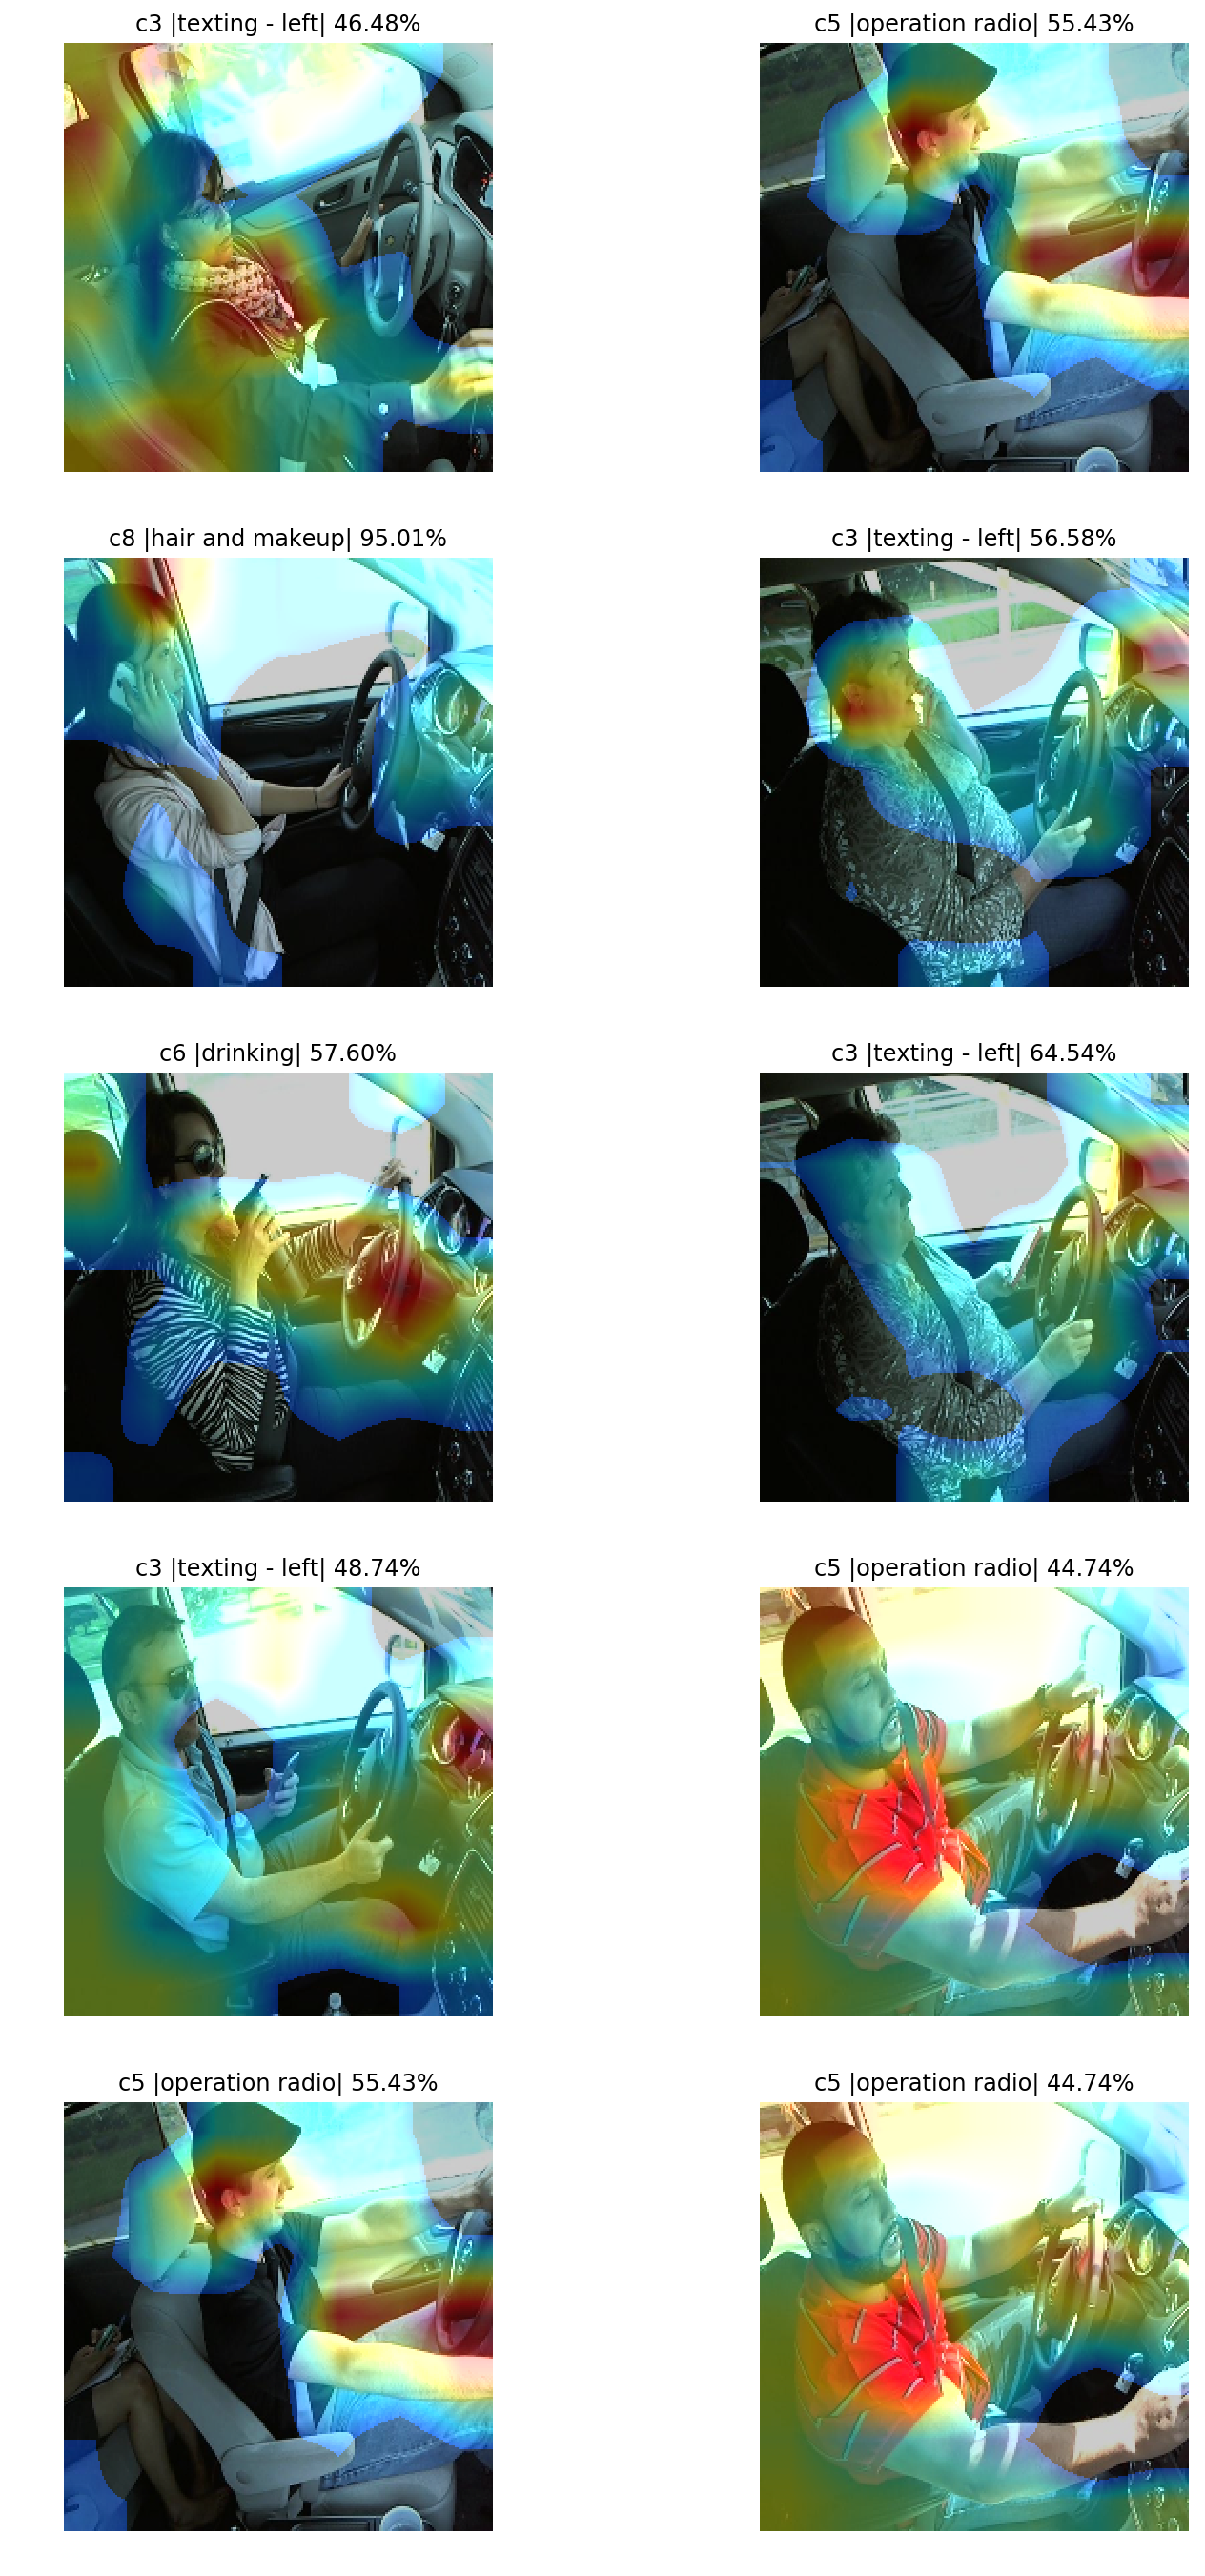

In [24]:
weights = model.layers[final_layer].get_weights()[0]
layer_output = model.layers[visual_layer].output
model2 = Model(model.input, [layer_output, model.output])
print("layer_output {0}".format(layer_output))
print("weights shape {0}".format(weights.shape))
show_heatmap_image(model2, weights)

In [25]:
weights = model.layers[final_layer].get_weights()[0]
layer_output = model.layers[visual_layer].output
model2 = Model(model.input, [layer_output, model.output])
print("layer_output {0}".format(layer_output))
print("weights shape {0}".format(weights.shape))
show_image(model2, weights)

layer_output Tensor("block5_pool_2/MaxPool:0", shape=(?, 7, 7, 512), dtype=float32)
weights shape (512, 10)


NameError: name 'show_image' is not defined

In [15]:
def gen_kaggle_csv(model,  model_image_size, csv_name):
    dir = "/ext/Data/distracted_driver_detection/"

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory(dir + "test/",  model_image_size, shuffle=False, 
                                             batch_size=batch_size, class_mode=None)
#     s = test_generator.__dict__
#     del s['filenames']
#     print(s)
    y_pred = model.predict_generator(test_generator,  steps=test_generator.samples//batch_size+1,  verbose=1)
    print("y_pred shape {}".format(y_pred.shape))
    y_pred = y_pred.clip(min=0.005, max=0.995)
    print(y_pred[:3])

    l = list()
    for i, fname in enumerate(test_generator.filenames):
        name = fname[fname.rfind('/')+1:]
        l.append( [name, *y_pred[i]] )

    l = np.array(l)
    data = {'img': l[:,0]}
    for i in range(10):
        data["c%d"%i] = l[:,i+1]
    df = pd.DataFrame(data, columns=['img'] + ['c%d'%i for i in range(10)])
    df.head(10)
    df = df.sort_values(by='img')
    df.to_csv(csv_name, index=None, float_format='%.3f')
    print("csv saved")

print("done")

done


In [16]:
gen_kaggle_csv(model,  model_image_size, 'csv/vgg19-imagenet-finetune{}-pred.csv'.format(fine_tune_layer))

Found 79726 images belonging to 1 classes.
1246/1246 [==============================] - 314s     